In [1]:
#强制关闭GPU
#对于深度2-5和隐藏单元数32-128较小的时候，CPU速度快。
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [2]:
import numpy as np
import tensorflow as tf
import h5py
import random
import time
import matplotlib.pyplot as plt
tf.reset_default_graph()
tf.test.is_gpu_available()

False

In [3]:
from scipy.io import loadmat#用于加载mat文件
# data_m= loadmat("E:\\AppliedEnergy投稿\\程序\\知识树\\train_data_withCorrelation2_10.mat")#mat-->dict字典。
data_m= loadmat("E:\\AppliedEnergy投稿\\开源数据\\大唐风电场\\月数据整理\\4train_data_withCorrelation_20.mat")#mat-->dict字典。
print(data_m.keys())#其中有很多key，注意找自己数据所在的那个
train_data = data_m["train_data"]#我需要的是这个，这是一个2998*10的矩阵
# print(type(train_data))
# print(np.shape(train_data))
# print(train_data)
# data_load = pd.DataFrame(data_load，columns=("load1","load2","load3","load4","load5","load6","load7","load8","load9","load10",))#给每列加上一个名字或者叫特征名，此时data_load就是一个dataframe类型了。
# print(data_load.head())#打印该df的前五行
# print(data_load.shape)
X1=[]
X2=[]
Y=[]
for i in range(1440):
    d=train_data[0][i]
    d=np.transpose(d)
    x1=d[2:][:][::-1]

    x2=d[0:2][::-1]

    y=d[0][-1]
    X1.append(x1)
    X2.append(x2)
    Y.append(y)
data_x1=np.array(X1)
data_x2=np.array(X2)
data_y=np.expand_dims(np.array(Y),axis=1)

##################分配训练测试集with sklearn Time Series Cross Validation
num=list(range(data_x1.shape[0]))
# print(num)

array=np.array(num)
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)#n_splits折交叉验证,n_splits折为n_splits+1份数据
list_train=[]
list_test=[]
for train, test in tscv.split(array):
    list_train.append(train)
    list_test.append(test)
#     print("%s %s" % (train, test))
# print(list_train)
# print(list_test)
#**********注意这部分要做3次*****************！！！！
num2=list_train[3] #3折交叉验证取0,1,2 
num1=list_test[3]  #3折交叉验证取0,1,2

# num2=list(range(0,144*8,1))
# num1=list(range(144*8,144*10,1))
# print(num2)
# print(num1)

#####################################
x1_train=data_x1[num2]
x2_train=data_x2[num2]
y_train=data_y[num2]
print('x1_train',np.shape(x1_train))
print('x2_train',np.shape(x2_train))
print('y_train',np.shape(y_train))
x1_test=data_x1[num1]
x2_test=data_x2[num1]
y_test=data_y[num1]
print('x1_test',np.shape(x1_test))
print('x2_test',np.shape(x2_test))
print('y_test',np.shape(y_test))
#生成批次
train_queue = tf.train.slice_input_producer([x1_train,x2_train,y_train],shuffle=None)
val_queue = tf.train.slice_input_producer([x1_test,x2_test,y_test],shuffle=None)

# batch_xt1,batch_xt2,batch_yt=tf.train.shuffle_batch(train_queue,batch_size=36,capacity=2000,min_after_dequeue=150)
# batch_xv1,batch_xv2,batch_yv=tf.train.shuffle_batch(val_queue,batch_size=36,capacity=2000,min_after_dequeue=150)
batch_xt1,batch_xt2,batch_yt=tf.train.batch(train_queue,batch_size=1152,capacity=1440)
batch_xv1,batch_xv2,batch_yv=tf.train.batch(val_queue,batch_size=288,capacity=1440)
print('batch_xv1',np.shape(batch_xv1))
print('batch_xv2',np.shape(batch_xv2))
print('batch_yv',np.shape(batch_yv))

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
x1_train (1152, 5, 55)
x2_train (1152, 2, 55)
y_train (1152, 1)
x1_test (288, 5, 55)
x2_test (288, 2, 55)
y_test (288, 1)
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replace

In [4]:
seq_length = batch_xt1.shape[1]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = batch_xt1.shape[0]  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!
de_length=2
output_dim = 1
# input_dim = 16  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 32 # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 4  # Number of stacked recurrent cells, on the neural depth axis. 
alpha=0.5#损失loss1函数占比
alpha_w=0.01#所有可以训练的参数的正则占比# L2 regularization of weights - avoids overfitting
# Optmizer: 
learning_rate = 0.005  # Small lr helps not to diverge during training. 
interval = 1 # show loss and acc every interval step
wholestep = 1 # 多少步运行完一个完整测试集，=测试集长度除批长度
max_iters = 500  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.9  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update

In [5]:
with tf.variable_scope('encoder'):

    # Encoder: inputs
    enc_inp1 = tf.placeholder(tf.float32, shape=(None,5,55), name="inp1")
    enc_inp2 = tf.placeholder(tf.float32, shape=(None,2,55), name="inp2")
    print('enc_inp1',np.shape(enc_inp1)) 
    print('enc_inp2',np.shape(enc_inp2))
    print('enc_inp2[:,0,:] 是recent data，enc_inp2[:,1,:]是future data')

    # Decoder: expected output
    expected_output = tf.placeholder(tf.float32, shape=(None,1), name="expected_output")
    pharse=tf.placeholder(tf.bool,name='training')

    # encoder cell 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
#             cells.append(tf.nn.rnn_cell.BasicLSTMCell(hidden_dim))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)

    enc_outputs, enc_memory = tf.nn.dynamic_rnn(cell,enc_inp1,dtype=tf.float32)
    print('enc_outputs',np.shape(enc_outputs))
    
with tf.variable_scope('decoder'):  
    decells=[]
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            decells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
#             decells.append(tf.nn.rnn_cell.BasicLSTMCell(hidden_dim))
    decell = tf.nn.rnn_cell.MultiRNNCell(decells)
    
    dec_state=enc_memory
    
    dec_inp=enc_inp2[:,1,-6:]
    dec_outputs=[]
    outs=[]
    #reshape expected_sparse_output
    w_h = tf.Variable(tf.random_normal([hidden_dim,6]))
    b_h = tf.Variable(tf.random_normal([6]))
    
#     dec_inputs=[tf.matmul(expected_sparse_output[:,i,:],w_h)+b_h for i in range(seq_length)]
    for time_step in range(de_length):
        if time_step>0:
            tf.get_variable_scope().reuse_variables()
        (dec_output,dec_state)=decell(dec_inp,dec_state)
        out1=tf.matmul(dec_output,w_h)+b_h
        if pharse==True:
            dec_inp=enc_inp2[:,time_step+1,-6:]
#             print('训练时dec_inp',np.shape(dec_inp[:,1,:]))   
        else:
            dec_inp=out1
#             print('测试时dec_inp','只输出out1')            
        outs.append(out1)
        dec_outputs.append(dec_output)

    print('dec_state',np.shape(dec_state))
#     (dec_output,dec_state)=decell(dec_inp,dec_state)
    
#     out1=tf.matmul(dec_output,w_h)+b_h

#     outs.append(out1)
#     dec_outputs.append(dec_output)
    
    # reshape seq2seq输出 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # 最终输出
    pre_output1=outs[0]
    pre_output2=tf.matmul(dec_outputs[-1],w_out)+b_out
    
    print(pre_output1.shape)
    print(pre_output2.shape)

enc_inp1 (?, 5, 55)
enc_inp2 (?, 2, 55)
enc_inp2[:,0,:] 是recent data，enc_inp2[:,1,:]是future data
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
enc_outputs (?, 5, 32)
dec_state (4,)
(?, 6)
(?, 1)


In [7]:
with tf.variable_scope('Loss'):
    # L2 loss
#     output_loss1 = tf.reduce_sum(tf.square(enc_inp2[:,1,:] - pre_output1)) #loss1 目标点之前到现在的点的MSE
#     output_loss2 = tf.reduce_sum(tf.square(expected_output - pre_output2)) #loss2 目标点的MSE
    
    output_loss1=tf.sqrt(tf.reduce_mean(tf.squared_difference(enc_inp2[:,1,-7:-1], pre_output1)))   #loss2 目标点的RMSE
    output_loss2=tf.sqrt(tf.reduce_mean(tf.squared_difference(expected_output, pre_output2)))   #loss2 目标点的RMSE

    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    
    loss = alpha*output_loss1+output_loss2+alpha_w*reg_loss       
#     loss = output_loss + lambda_l2_reg * reg_loss
    loss = output_loss2+alpha_w*reg_loss
#     loss = output_loss2
    tf.summary.scalar('loss',loss)

with tf.variable_scope('Optimizer'):
#     optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    #使用梯度下降法
#     optimizer = tf.train.GradientDescentOptimizer(0.5)
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
    
    train_op = optimizer.minimize(loss)
    merged_summary = tf.summary.merge_all()
    
# 加一些评价指标
with tf.variable_scope('ACC'): 
    if expected_output==0:
        acc = 1
    else:
        acc = 1-tf.reduce_mean(tf.sqrt(tf.square(expected_output-pre_output2))/tf.sqrt(tf.square(expected_output)),axis=(0,1))
    tf.summary.scalar('ACC',acc)
    
with tf.variable_scope('RMSE'):
    rmse=tf.sqrt(tf.reduce_mean(tf.squared_difference(pre_output2, expected_output)))
    tf.summary.scalar('RMSE',rmse) 


# from sklearn.metrics import r2_score
with tf.variable_scope('R_square'):
    unexplained_error = tf.reduce_sum(tf.square(expected_output - pre_output2))
    total_error = tf.reduce_sum(tf.square(expected_output - tf.reduce_mean(expected_output, axis=0)))
    r_square = 1. - tf.div(unexplained_error, total_error)
#     r_square=r2_score(pre_output2, expected_output)
    tf.summary.scalar('R_square',r_square) 

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [8]:
min_loss=1e10
sess=tf.Session()
# train_writer=tf.summary.FileWriter('graph/train/',sess.graph)
# test_writer = tf.summary.FileWriter('graph/test/', sess.graph)
# saver=tf.train.Saver(max_to_keep=3)

init_op = tf.global_variables_initializer()
sess.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess, coord)
max_acc=0.5
min_loss=10000
t1=time.time()
# 按间隔定义方式：fig_accuracy = np.zeros(int(np.ceil(iteration / interval)))
fig_loss_train = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_acc_train = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_rmse_train = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_r_square_train = np.zeros(int(np.ceil((max_iters+1) / interval)))

fig_loss_test = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_acc_test = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_rmse_test = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_r_square_test = np.zeros(int(np.ceil((max_iters+1) / interval)))

for training_itr in range(max_iters):
    x1, x2, y = sess.run([batch_xt1,batch_xt2,batch_yt])
    feed_dict1 = {enc_inp1: x1}
    feed_dict1.update({enc_inp2:x2})
    feed_dict1.update({expected_output: y})
    feed_dict1.update({pharse:True})
#     _, loss1,acc1,summaries1 = sess.run([train_op, loss,acc,merged_summary], feed_dict1)
    _, loss1,acc1,rmse1,r_square1,summaries1 = sess.run([train_op,loss,acc,rmse,r_square,merged_summary], feed_dict1)
#     train_writer.add_summary(summaries1, training_itr)

    if (training_itr+1) % interval==0:
        tt=time.time()        
    # 每interval个epoch验证1次
        
        test_acc = 0.0
        test_loss = 0.0
        test_rmse = 0.0
        test_r_square = 0.0
        
        N = wholestep
        for j in range(N):
            test_x1,test_x2,test_y=sess.run([batch_xv1,batch_xv2,batch_yv])
            feed_dict2 = {enc_inp1:test_x1}
            feed_dict2.update({enc_inp2:test_x2})
            feed_dict2.update({expected_output: test_y})
            feed_dict2.update({pharse:False})
        
#             loss2,acc2,summaries2 = sess.run([loss,acc,merged_summary], feed_dict2)
            loss2,acc2,rmse2,r_square2,summaries2 = sess.run([loss,acc,rmse,r_square,merged_summary], feed_dict2) 
            test_acc+=acc2
            test_loss+=loss2
            test_rmse+=rmse2
            test_r_square+=r_square2
           
        print('step: {} time:{}'.format(training_itr+1,time.time()-tt))
        print('Train: loss: {} acc: {} rmse: {} r_square: {}'.format(loss1,acc1,rmse1,r_square1))
        print('Val:   loss: {} acc: {} rmse: {} r_square: {}'.format(loss2,acc2,rmse2,r_square2))

        fig_loss_train[int(np.ceil((training_itr+1)/ interval))]=loss1
        fig_acc_train[int(np.ceil((training_itr+1)/ interval))]=acc1
        fig_rmse_train[int(np.ceil((training_itr+1)/ interval))]=rmse1
        fig_r_square_train[int(np.ceil((training_itr+1)/ interval))]=r_square1

        fig_loss_test[int(np.ceil((training_itr+1)/ interval))]=test_loss/N
        fig_acc_test[int(np.ceil((training_itr+1)/ interval))]=test_acc/N
        fig_rmse_test[int(np.ceil((training_itr+1)/ interval))]=test_rmse/N
        fig_r_square_test[int(np.ceil((training_itr+1)/ interval))]=test_r_square/N
        
#         if test_loss/N<min_loss:
#             min_loss=test_loss/N
        if loss1<min_loss:
            min_loss=loss1
            test_acc_aver=test_acc/N
            test_loss_aver=test_loss/N
            test_rmse_aver=test_rmse/N
            test_r_square_aver=test_r_square/N
            train_acc_aver=acc1
            train_loss_aver=min_loss
            train_rmse_aver=rmse1
            train_r_square_aver=r_square1
            fig_prediction=sess.run(pre_output2, feed_dict={enc_inp1: test_x1,enc_inp2:test_x2})
            fig_val=test_y
            
#         test_writer.add_summary(summaries2, training_itr)
#         if loss1 < min_loss:
#             min_loss=loss1
#             saver.save(sess=sess, save_path='model/model.ckpt',global_step=(training_itr + 1))

total_time=time.time()-t1
coord.request_stop()
coord.join(threads)
sess.close()
print('final time:',total_time)
# print('test 1-MAPE:',test_acc_aver)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
step: 1 time:0.19946527481079102
Train: loss: 16.47602081298828 acc: 0.06271147727966309 rmse: 8.60897445678711 r_square: -9.3351411819458
Val:   loss: 15.925207138061523 acc: 0.3051733374595642 rmse: 8.253564834594727 r_square: -2.5892961025238037
step: 2 time:0.0050046443939208984
Train: loss: 14.50791072845459 acc: 0.2782704830169678 rmse: 6.836267948150635 r_square: -5.517059326171875
Val:   loss: 14.175825119018555 acc: 0.42609530687332153 rmse: 6.682035446166992 r_square: -1.3525760173797607
step: 3 time:0.005987644195556641
Train: loss: 12.60310173034668 acc: 0.4639933109283447 rmse: 5.109311103820801 r_square: -2.6403086185455322
Val:   loss: 12.411397933959961 acc: 0.4708455801010132 rmse: 5.077886581420898 r_square: -0.358601450920105
step: 4 time:0.004987239837646484
Train: loss: 10.646586418151855 acc: 0.6087572574615479 rmse: 3.313075065612793 r_square: -0.5306506156921387
Val:   loss: 11.48

step: 33 time:0.005983591079711914
Train: loss: 5.529857158660889 acc: 0.8489424586296082 rmse: 1.144978404045105 r_square: 0.8171865940093994
Val:   loss: 6.870428562164307 acc: 0.7738564014434814 rmse: 2.5394349098205566 r_square: 0.6602180600166321
step: 34 time:0.003988504409790039
Train: loss: 5.334127426147461 acc: 0.873847484588623 rmse: 1.0031338930130005 r_square: 0.8596762418746948
Val:   loss: 6.514735221862793 acc: 0.7831780910491943 rmse: 2.236130714416504 r_square: 0.7365365028381348
step: 35 time:0.00399017333984375
Train: loss: 5.154478073120117 acc: 0.8766223788261414 rmse: 0.875873327255249 r_square: 0.8930215835571289
Val:   loss: 6.39408016204834 acc: 0.7821633815765381 rmse: 2.166951894760132 r_square: 0.752585768699646
step: 36 time:0.004988193511962891
Train: loss: 5.019355773925781 acc: 0.885148823261261 rmse: 0.7922283411026001 r_square: 0.9124786257743835
Val:   loss: 6.110488414764404 acc: 0.7698488831520081 rmse: 1.9333586692810059 r_square: 0.80305224657058

step: 66 time:0.005986690521240234
Train: loss: 4.713790416717529 acc: 0.7802727222442627 rmse: 1.4958590269088745 r_square: 0.6879710555076599
Val:   loss: 5.048723220825195 acc: 0.6960273385047913 rmse: 1.8548164367675781 r_square: 0.8187291622161865
step: 67 time:0.005984306335449219
Train: loss: 5.125818252563477 acc: 0.7244657874107361 rmse: 1.9319124221801758 r_square: 0.4795386791229248
Val:   loss: 4.604799270629883 acc: 0.772135317325592 rmse: 1.4356886148452759 r_square: 0.8913958072662354
step: 68 time:0.006983518600463867
Train: loss: 4.431802272796631 acc: 0.8138636350631714 rmse: 1.2626920938491821 r_square: 0.7776646614074707
Val:   loss: 4.491649627685547 acc: 0.8779805898666382 rmse: 1.347386121749878 r_square: 0.9043444395065308
step: 69 time:0.0039882659912109375
Train: loss: 3.6350655555725098 acc: 0.9436306953430176 rmse: 0.49080216884613037 r_square: 0.9664087295532227
Val:   loss: 4.823085784912109 acc: 0.8476557731628418 rmse: 1.7021970748901367 r_square: 0.8473

step: 99 time:0.003989696502685547
Train: loss: 2.7752981185913086 acc: 0.9664924740791321 rmse: 0.221879243850708 r_square: 0.9931349158287048
Val:   loss: 3.3285346031188965 acc: 0.9383933544158936 rmse: 0.7924977540969849 r_square: 0.9669080376625061
step: 100 time:0.0039823055267333984
Train: loss: 2.7310972213745117 acc: 0.9729931354522705 rmse: 0.1950603425502777 r_square: 0.994694173336029
Val:   loss: 3.242311477661133 acc: 0.9273017644882202 rmse: 0.7230827808380127 r_square: 0.9724512100219727
step: 101 time:0.004986286163330078
Train: loss: 2.8275184631347656 acc: 0.9551621675491333 rmse: 0.30828970670700073 r_square: 0.9867464900016785
Val:   loss: 3.3223109245300293 acc: 0.9330704212188721 rmse: 0.8203047513961792 r_square: 0.9645450711250305
step: 102 time:0.005975484848022461
Train: loss: 2.800370216369629 acc: 0.9590117931365967 rmse: 0.2983640730381012 r_square: 0.9875861406326294
Val:   loss: 3.1972591876983643 acc: 0.9381076097488403 rmse: 0.7118802666664124 r_square

step: 134 time:0.008971214294433594
Train: loss: 2.197237253189087 acc: 0.9799714088439941 rmse: 0.1588670313358307 r_square: 0.9964805245399475
Val:   loss: 2.7534656524658203 acc: 0.9275320172309875 rmse: 0.726881742477417 r_square: 0.9721609950065613
step: 135 time:0.007977485656738281
Train: loss: 2.3791942596435547 acc: 0.9522229433059692 rmse: 0.35261043906211853 r_square: 0.982661783695221
Val:   loss: 2.7847495079040527 acc: 0.9487663507461548 rmse: 0.7705069780349731 r_square: 0.9687191247940063
step: 136 time:0.004984378814697266
Train: loss: 2.1619787216186523 acc: 0.981485903263092 rmse: 0.1477362960577011 r_square: 0.9969564080238342
Val:   loss: 2.721187114715576 acc: 0.9467661380767822 rmse: 0.7187037467956543 r_square: 0.9727839231491089
step: 137 time:0.005983829498291016
Train: loss: 2.162339448928833 acc: 0.9780787229537964 rmse: 0.1598561406135559 r_square: 0.9964365363121033
Val:   loss: 2.860841751098633 acc: 0.9293748140335083 rmse: 0.8704233169555664 r_square: 0

step: 169 time:0.003989696502685547
Train: loss: 1.8941363096237183 acc: 0.9754889011383057 rmse: 0.21520163118839264 r_square: 0.9935418963432312
Val:   loss: 2.8961477279663086 acc: 0.9033513069152832 rmse: 1.2262126207351685 r_square: 0.920775830745697
step: 170 time:0.004987001419067383
Train: loss: 2.2082669734954834 acc: 0.9320560693740845 rmse: 0.5383318066596985 r_square: 0.9595876932144165
Val:   loss: 2.8370742797851562 acc: 0.917768657207489 rmse: 1.1754878759384155 r_square: 0.9271947741508484
step: 171 time:0.0039882659912109375
Train: loss: 2.0416886806488037 acc: 0.9565722346305847 rmse: 0.3801020085811615 r_square: 0.9798528552055359
Val:   loss: 2.702436923980713 acc: 0.8883699178695679 rmse: 1.0484930276870728 r_square: 0.9420762062072754
step: 172 time:0.004986286163330078
Train: loss: 2.104255199432373 acc: 0.9311015605926514 rmse: 0.4503112733364105 r_square: 0.9717226028442383
Val:   loss: 2.706347942352295 acc: 0.8795492649078369 rmse: 1.0604639053344727 r_square

step: 203 time:0.0049860477447509766
Train: loss: 1.640714168548584 acc: 0.9712185263633728 rmse: 0.21268413960933685 r_square: 0.9936921000480652
Val:   loss: 2.307137966156006 acc: 0.9360209107398987 rmse: 0.8861806988716125 r_square: 0.9586218595504761
step: 204 time:0.004987239837646484
Train: loss: 1.7478320598602295 acc: 0.9596445560455322 rmse: 0.32687488198280334 r_square: 0.9851003289222717
Val:   loss: 2.214325189590454 acc: 0.9468843936920166 rmse: 0.799775242805481 r_square: 0.9662975072860718
step: 205 time:0.0049860477447509766
Train: loss: 1.566490650177002 acc: 0.9818511009216309 rmse: 0.1519407033920288 r_square: 0.9967806935310364
Val:   loss: 2.1536865234375 acc: 0.9169012904167175 rmse: 0.7448691129684448 r_square: 0.9707661271095276
step: 206 time:0.0069849491119384766
Train: loss: 1.9024875164031982 acc: 0.9330763816833496 rmse: 0.49366995692253113 r_square: 0.9660150408744812
Val:   loss: 2.0825977325439453 acc: 0.9467774629592896 rmse: 0.6801953315734863 r_squar

step: 235 time:0.0049860477447509766
Train: loss: 1.3685498237609863 acc: 0.9845391511917114 rmse: 0.12342793494462967 r_square: 0.9978755712509155
Val:   loss: 2.00528621673584 acc: 0.9541925191879272 rmse: 0.765268862247467 r_square: 0.9691429734230042
step: 236 time:0.005984306335449219
Train: loss: 1.381534218788147 acc: 0.9835774898529053 rmse: 0.1415168046951294 r_square: 0.9972072839736938
Val:   loss: 1.9297504425048828 acc: 0.9415975213050842 rmse: 0.6942607760429382 r_square: 0.9746036529541016
step: 237 time:0.006982326507568359
Train: loss: 1.4925698041915894 acc: 0.9639023542404175 rmse: 0.2570800483226776 r_square: 0.9907838106155396
Val:   loss: 1.9721788167953491 acc: 0.9537452459335327 rmse: 0.7417336702346802 r_square: 0.971011757850647
step: 238 time:0.006981372833251953
Train: loss: 1.3801336288452148 acc: 0.9809421896934509 rmse: 0.14968842267990112 r_square: 0.9968754053115845
Val:   loss: 1.895603895187378 acc: 0.9561108350753784 rmse: 0.6697260141372681 r_square

step: 267 time:0.004986286163330078
Train: loss: 1.752333402633667 acc: 0.9291231036186218 rmse: 0.6497601270675659 r_square: 0.9411265254020691
Val:   loss: 1.9883759021759033 acc: 0.938908040523529 rmse: 0.8886361718177795 r_square: 0.9583922624588013
step: 268 time:0.00498652458190918
Train: loss: 1.3046534061431885 acc: 0.9774376749992371 rmse: 0.20491360127925873 r_square: 0.9941446185112
Val:   loss: 1.9639103412628174 acc: 0.9316316246986389 rmse: 0.8673517107963562 r_square: 0.9603615403175354
step: 269 time:0.004986286163330078
Train: loss: 1.5259064435958862 acc: 0.953824520111084 rmse: 0.42934778332710266 r_square: 0.974294126033783
Val:   loss: 2.037844657897949 acc: 0.937835156917572 rmse: 0.9452763199806213 r_square: 0.9529192447662354
step: 270 time:0.006973981857299805
Train: loss: 1.3177447319030762 acc: 0.9740984439849854 rmse: 0.2251763939857483 r_square: 0.9929293394088745
Val:   loss: 2.1950039863586426 acc: 0.9190352559089661 rmse: 1.1064844131469727 r_square: 0.9

step: 300 time:0.0049877166748046875
Train: loss: 1.3122304677963257 acc: 0.9578772187232971 rmse: 0.31466472148895264 r_square: 0.9861926436424255
Val:   loss: 1.6419740915298462 acc: 0.9558284878730774 rmse: 0.6468538641929626 r_square: 0.9779535531997681
step: 301 time:0.004987955093383789
Train: loss: 1.1757514476776123 acc: 0.9792960286140442 rmse: 0.18063125014305115 r_square: 0.9954501390457153
Val:   loss: 1.6287975311279297 acc: 0.9575104713439941 rmse: 0.6368828415870667 r_square: 0.9786279797554016
step: 302 time:0.00498652458190918
Train: loss: 1.2375068664550781 acc: 0.9729210734367371 rmse: 0.24559225142002106 r_square: 0.9915890693664551
Val:   loss: 1.7971869707107544 acc: 0.9467224478721619 rmse: 0.8092511892318726 r_square: 0.9654941558837891
step: 303 time:0.003986835479736328
Train: loss: 1.2392830848693848 acc: 0.9696794748306274 rmse: 0.25134721398353577 r_square: 0.9911903142929077
Val:   loss: 1.7662320137023926 acc: 0.9394550919532776 rmse: 0.7815127968788147 r

step: 333 time:0.004988193511962891
Train: loss: 1.25355064868927 acc: 0.9588373899459839 rmse: 0.3489106595516205 r_square: 0.9830237627029419
Val:   loss: 1.5946820974349976 acc: 0.955733060836792 rmse: 0.6921572685241699 r_square: 0.9747573137283325
step: 334 time:0.004984855651855469
Train: loss: 1.0180633068084717 acc: 0.9844599366188049 rmse: 0.11553848534822464 r_square: 0.9981384873390198
Val:   loss: 1.5805766582489014 acc: 0.9629067778587341 rmse: 0.6803861856460571 r_square: 0.9756085872650146
step: 335 time:0.0049860477447509766
Train: loss: 0.9870726466178894 acc: 0.9909345507621765 rmse: 0.08688215911388397 r_square: 0.9989473819732666
Val:   loss: 1.600602626800537 acc: 0.9585567712783813 rmse: 0.7029003500938416 r_square: 0.9739676117897034
step: 336 time:0.00498509407043457
Train: loss: 1.0143014192581177 acc: 0.9850744605064392 rmse: 0.11659903824329376 r_square: 0.9981041550636292
Val:   loss: 1.5718566179275513 acc: 0.9366694092750549 rmse: 0.6763176321983337 r_squa

step: 367 time:0.004987001419067383
Train: loss: 1.02767813205719 acc: 0.9760897159576416 rmse: 0.19794318079948425 r_square: 0.9945362210273743
Val:   loss: 1.83688223361969 acc: 0.8932709693908691 rmse: 1.0097408294677734 r_square: 0.9462787508964539
step: 368 time:0.003987550735473633
Train: loss: 1.5103540420532227 acc: 0.909465491771698 rmse: 0.6832126379013062 r_square: 0.9349083304405212
Val:   loss: 1.8882372379302979 acc: 0.8849141001701355 rmse: 1.063165545463562 r_square: 0.9404436945915222
step: 369 time:0.003988027572631836
Train: loss: 1.5742429494857788 acc: 0.9003843069076538 rmse: 0.749171257019043 r_square: 0.9217334985733032
Val:   loss: 1.5141723155975342 acc: 0.9553576111793518 rmse: 0.6907364726066589 r_square: 0.9748608469963074
step: 370 time:0.003989696502685547
Train: loss: 0.9645700454711914 acc: 0.9809726476669312 rmse: 0.1411340832710266 r_square: 0.997222363948822
Val:   loss: 1.7846333980560303 acc: 0.8627713918685913 rmse: 0.9625064730644226 r_square: 0.

step: 401 time:0.0049860477447509766
Train: loss: 0.9585776329040527 acc: 0.9819661378860474 rmse: 0.18735447525978088 r_square: 0.9951051473617554
Val:   loss: 1.6839540004730225 acc: 0.9399601817131042 rmse: 0.9140641689300537 r_square: 0.9559770226478577
step: 402 time:0.004983663558959961
Train: loss: 1.101585865020752 acc: 0.9624486565589905 rmse: 0.3316959738731384 r_square: 0.9846575856208801
Val:   loss: 1.725162386894226 acc: 0.9480262994766235 rmse: 0.9572676420211792 r_square: 0.9517171382904053
step: 403 time:0.00498652458190918
Train: loss: 0.9262821078300476 acc: 0.9852076768875122 rmse: 0.15838728845119476 r_square: 0.9965017437934875
Val:   loss: 1.8168319463729858 acc: 0.9384449124336243 rmse: 1.0507780313491821 r_square: 0.941823422908783
step: 404 time:0.0039899349212646484
Train: loss: 1.0611982345581055 acc: 0.96750807762146 rmse: 0.29514431953430176 r_square: 0.9878526329994202
Val:   loss: 1.7387712001800537 acc: 0.9420877695083618 rmse: 0.9739177227020264 r_squa

step: 434 time:0.004987478256225586
Train: loss: 1.0533207654953003 acc: 0.9553688168525696 rmse: 0.3294680714607239 r_square: 0.9848629832267761
Val:   loss: 1.4832559823989868 acc: 0.936678409576416 rmse: 0.7609438896179199 r_square: 0.9694907665252686
step: 435 time:0.004885435104370117
Train: loss: 1.0321412086486816 acc: 0.9574649930000305 rmse: 0.3098291754722595 r_square: 0.9866137504577637
Val:   loss: 1.5994726419448853 acc: 0.944499135017395 rmse: 0.8791986107826233 r_square: 0.9592713117599487
step: 436 time:0.00498652458190918
Train: loss: 0.9800015091896057 acc: 0.9682307839393616 rmse: 0.25972747802734375 r_square: 0.9905930161476135
Val:   loss: 1.5900213718414307 acc: 0.9457219839096069 rmse: 0.8711912631988525 r_square: 0.9600098133087158
step: 437 time:0.0049860477447509766
Train: loss: 0.9629846811294556 acc: 0.9700104594230652 rmse: 0.24415448307991028 r_square: 0.9916872978210449
Val:   loss: 1.477487325668335 acc: 0.9397628903388977 rmse: 0.7595765590667725 r_squa

step: 467 time:0.00498509407043457
Train: loss: 0.9553437829017639 acc: 0.9638029336929321 rmse: 0.27532947063446045 r_square: 0.9894289374351501
Val:   loss: 1.569200038909912 acc: 0.9430527091026306 rmse: 0.8909519910812378 r_square: 0.9581751227378845
step: 468 time:0.004983425140380859
Train: loss: 0.9543265104293823 acc: 0.9666069149971008 rmse: 0.276078462600708 r_square: 0.9893713593482971
Val:   loss: 1.5567262172698975 acc: 0.9456693530082703 rmse: 0.8796632885932922 r_square: 0.9592282772064209
step: 469 time:0.004987478256225586
Train: loss: 0.9290229082107544 acc: 0.9698198437690735 rmse: 0.25196006894111633 r_square: 0.9911472797393799
Val:   loss: 1.4399476051330566 acc: 0.9394448399543762 rmse: 0.7635313272476196 r_square: 0.9692829251289368
step: 470 time:0.004987239837646484
Train: loss: 0.9666602611541748 acc: 0.9608400464057922 rmse: 0.29024404287338257 r_square: 0.9882526397705078
Val:   loss: 1.4343676567077637 acc: 0.9448656439781189 rmse: 0.7591708302497864 r_squ

final time: 48.07332944869995


In [9]:
#**********注意这部分要做10次，取平均值
print('final time:',total_time)
print('epoch size:',max_iters*wholestep)
print('Training evaluation:',train_acc_aver,train_rmse_aver,train_r_square_aver) #10000代结果
print('Testing evaluation:',test_acc_aver,test_rmse_aver,test_r_square_aver) #10000代结果
# print('Training loss:',train_loss_aver) #10000代结果
# print('Testing loss:',test_loss_aver) #10000代结果

final time: 48.07332944869995
epoch size: 500
Training evaluation: 0.96670276 0.2439465 0.9917014
Testing evaluation: 0.9411224722862244 0.8890968561172485 0.9583491086959839


Text(0, 0.5, 'ACC')

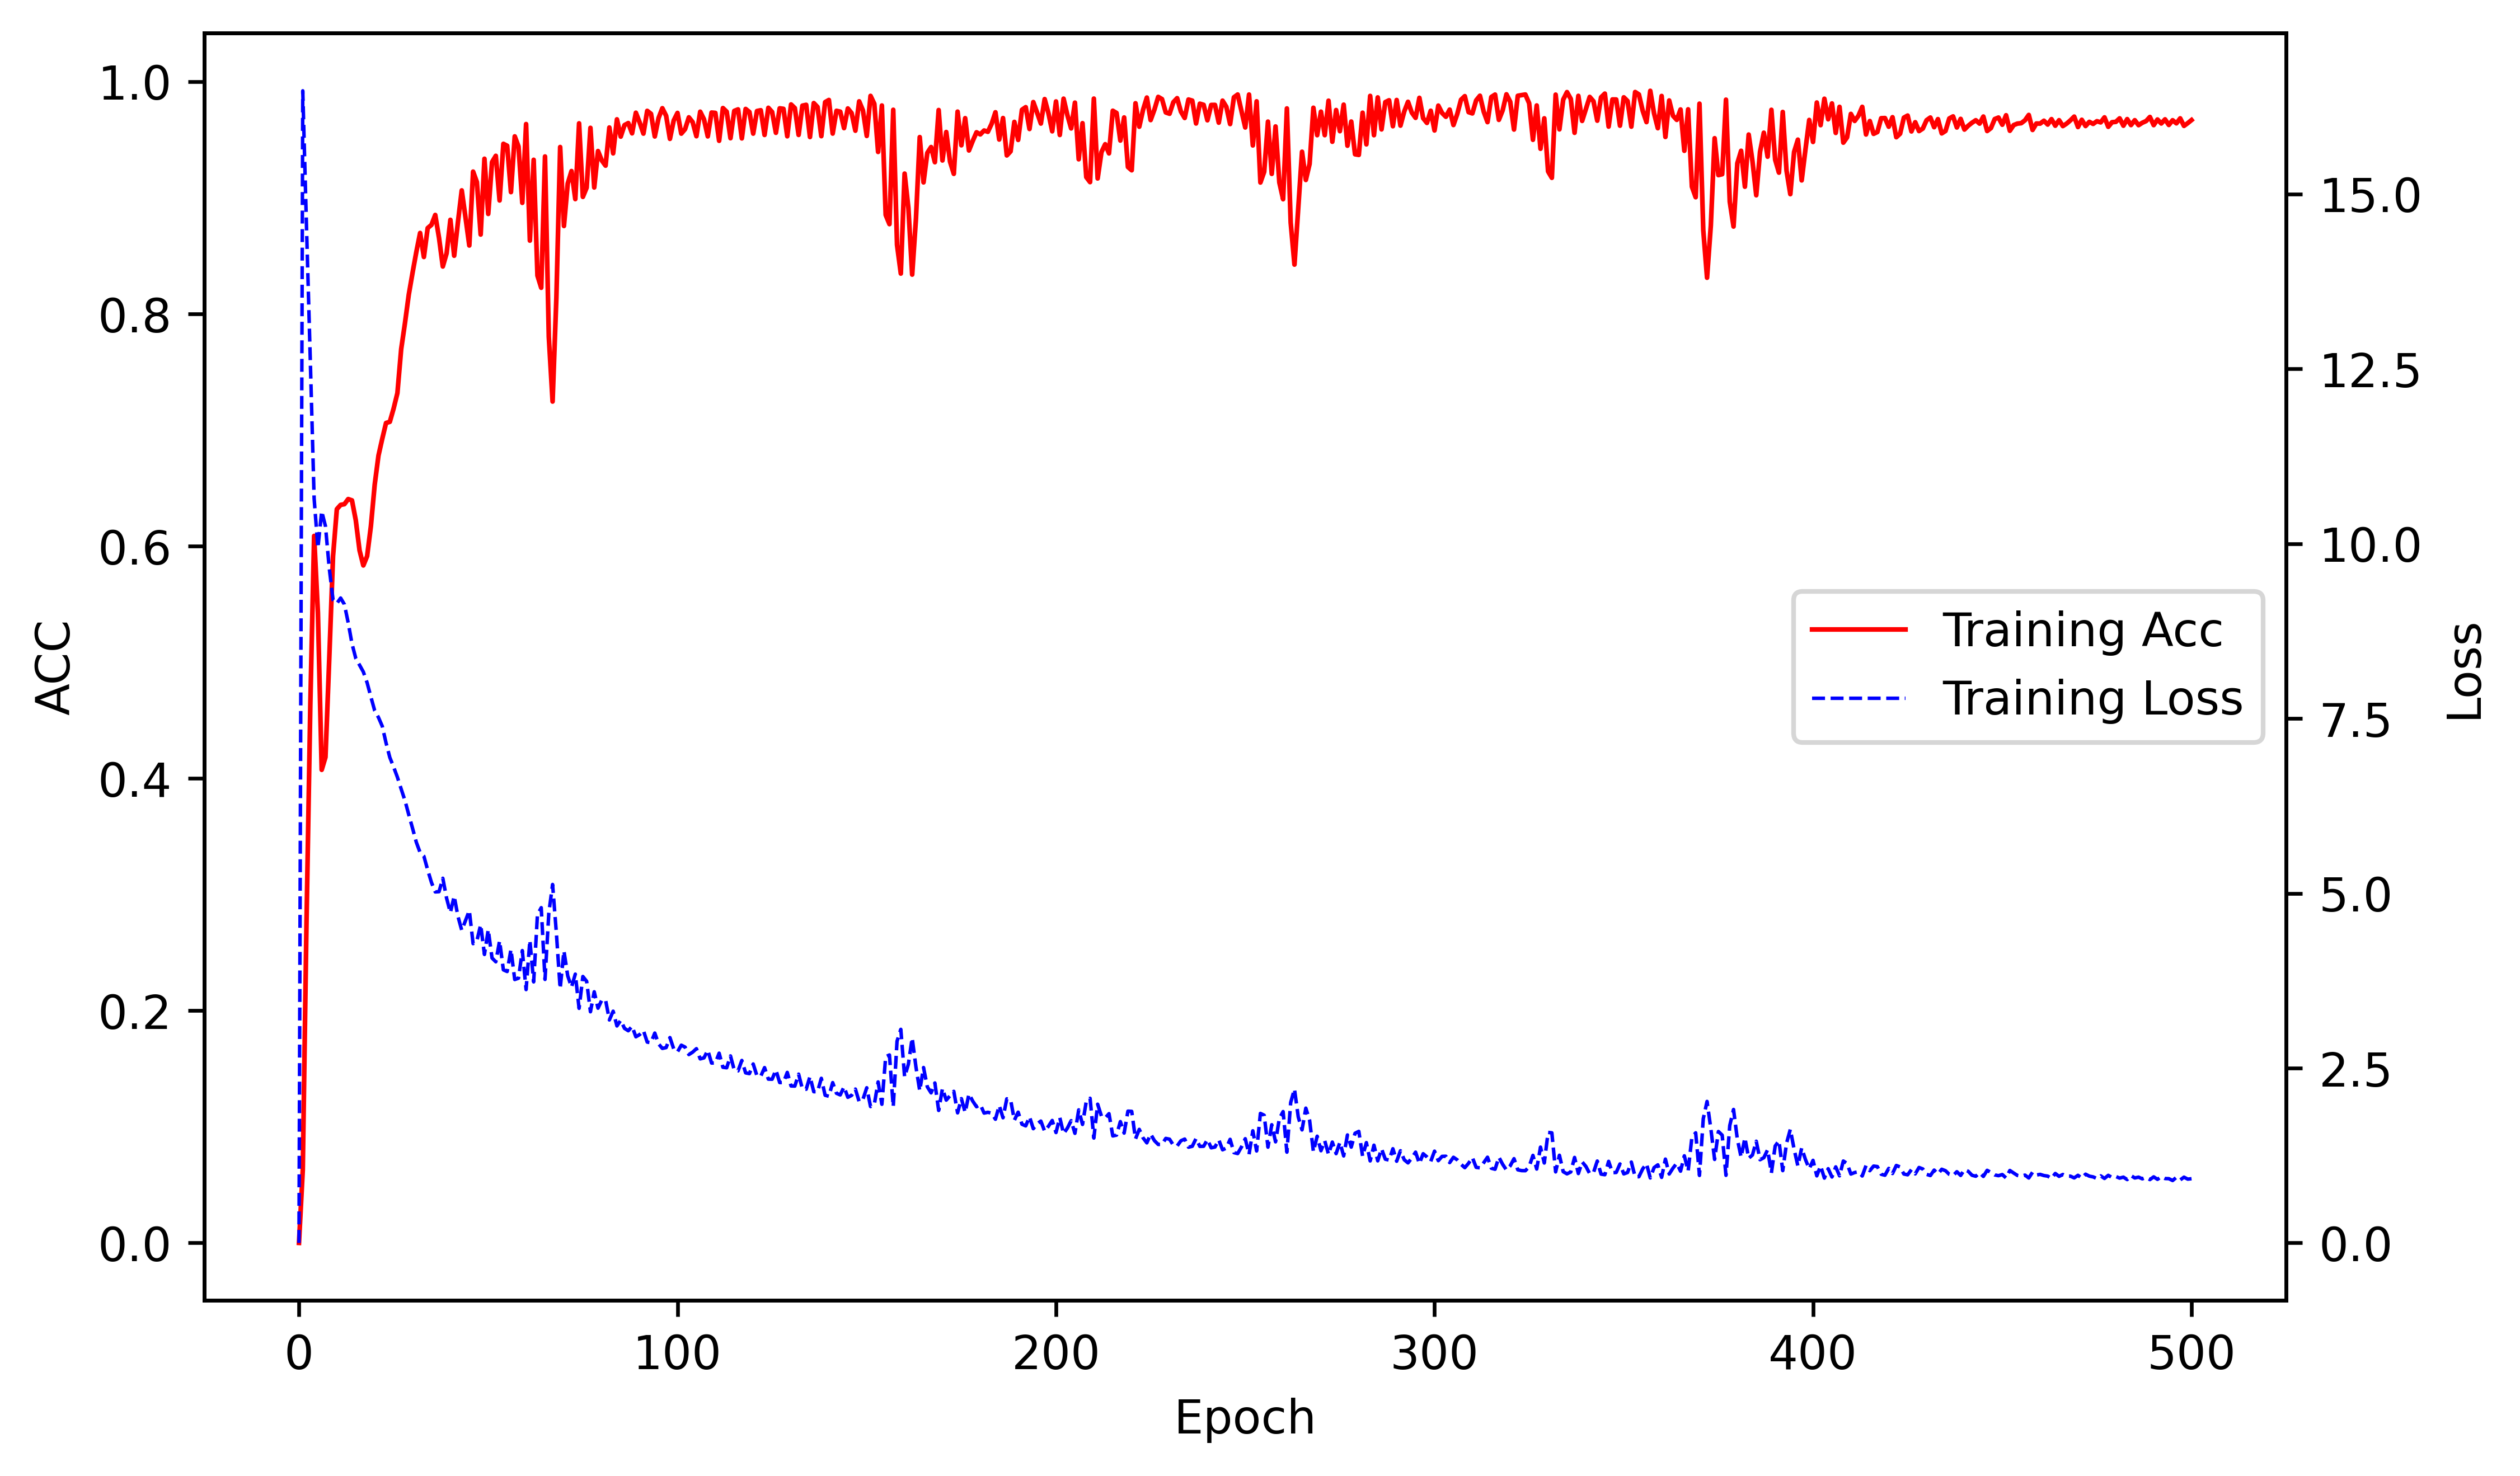

In [10]:
fig, ax1 = plt.subplots(figsize=(8, 5),dpi=600)
ax2 = ax1.twinx()
lns_TrainingAcc = ax1.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_acc_train, color='red', linewidth=1, linestyle='-', label="Training Acc")
lns_TrainingLoss=ax2.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_loss_train, color='blue', linewidth=0.75, linestyle='--', label="Training Loss")
lns_LossAcc=lns_TrainingAcc+lns_TrainingLoss
label_TrainingAcc=["Training Acc"]
label_TrainingLoss=["Training Loss"]
label_Acc=label_TrainingAcc+label_TrainingLoss
plt.legend(lns_LossAcc,label_Acc, loc=5)
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_ylabel('ACC')

Text(0, 0.5, 'RMSE')

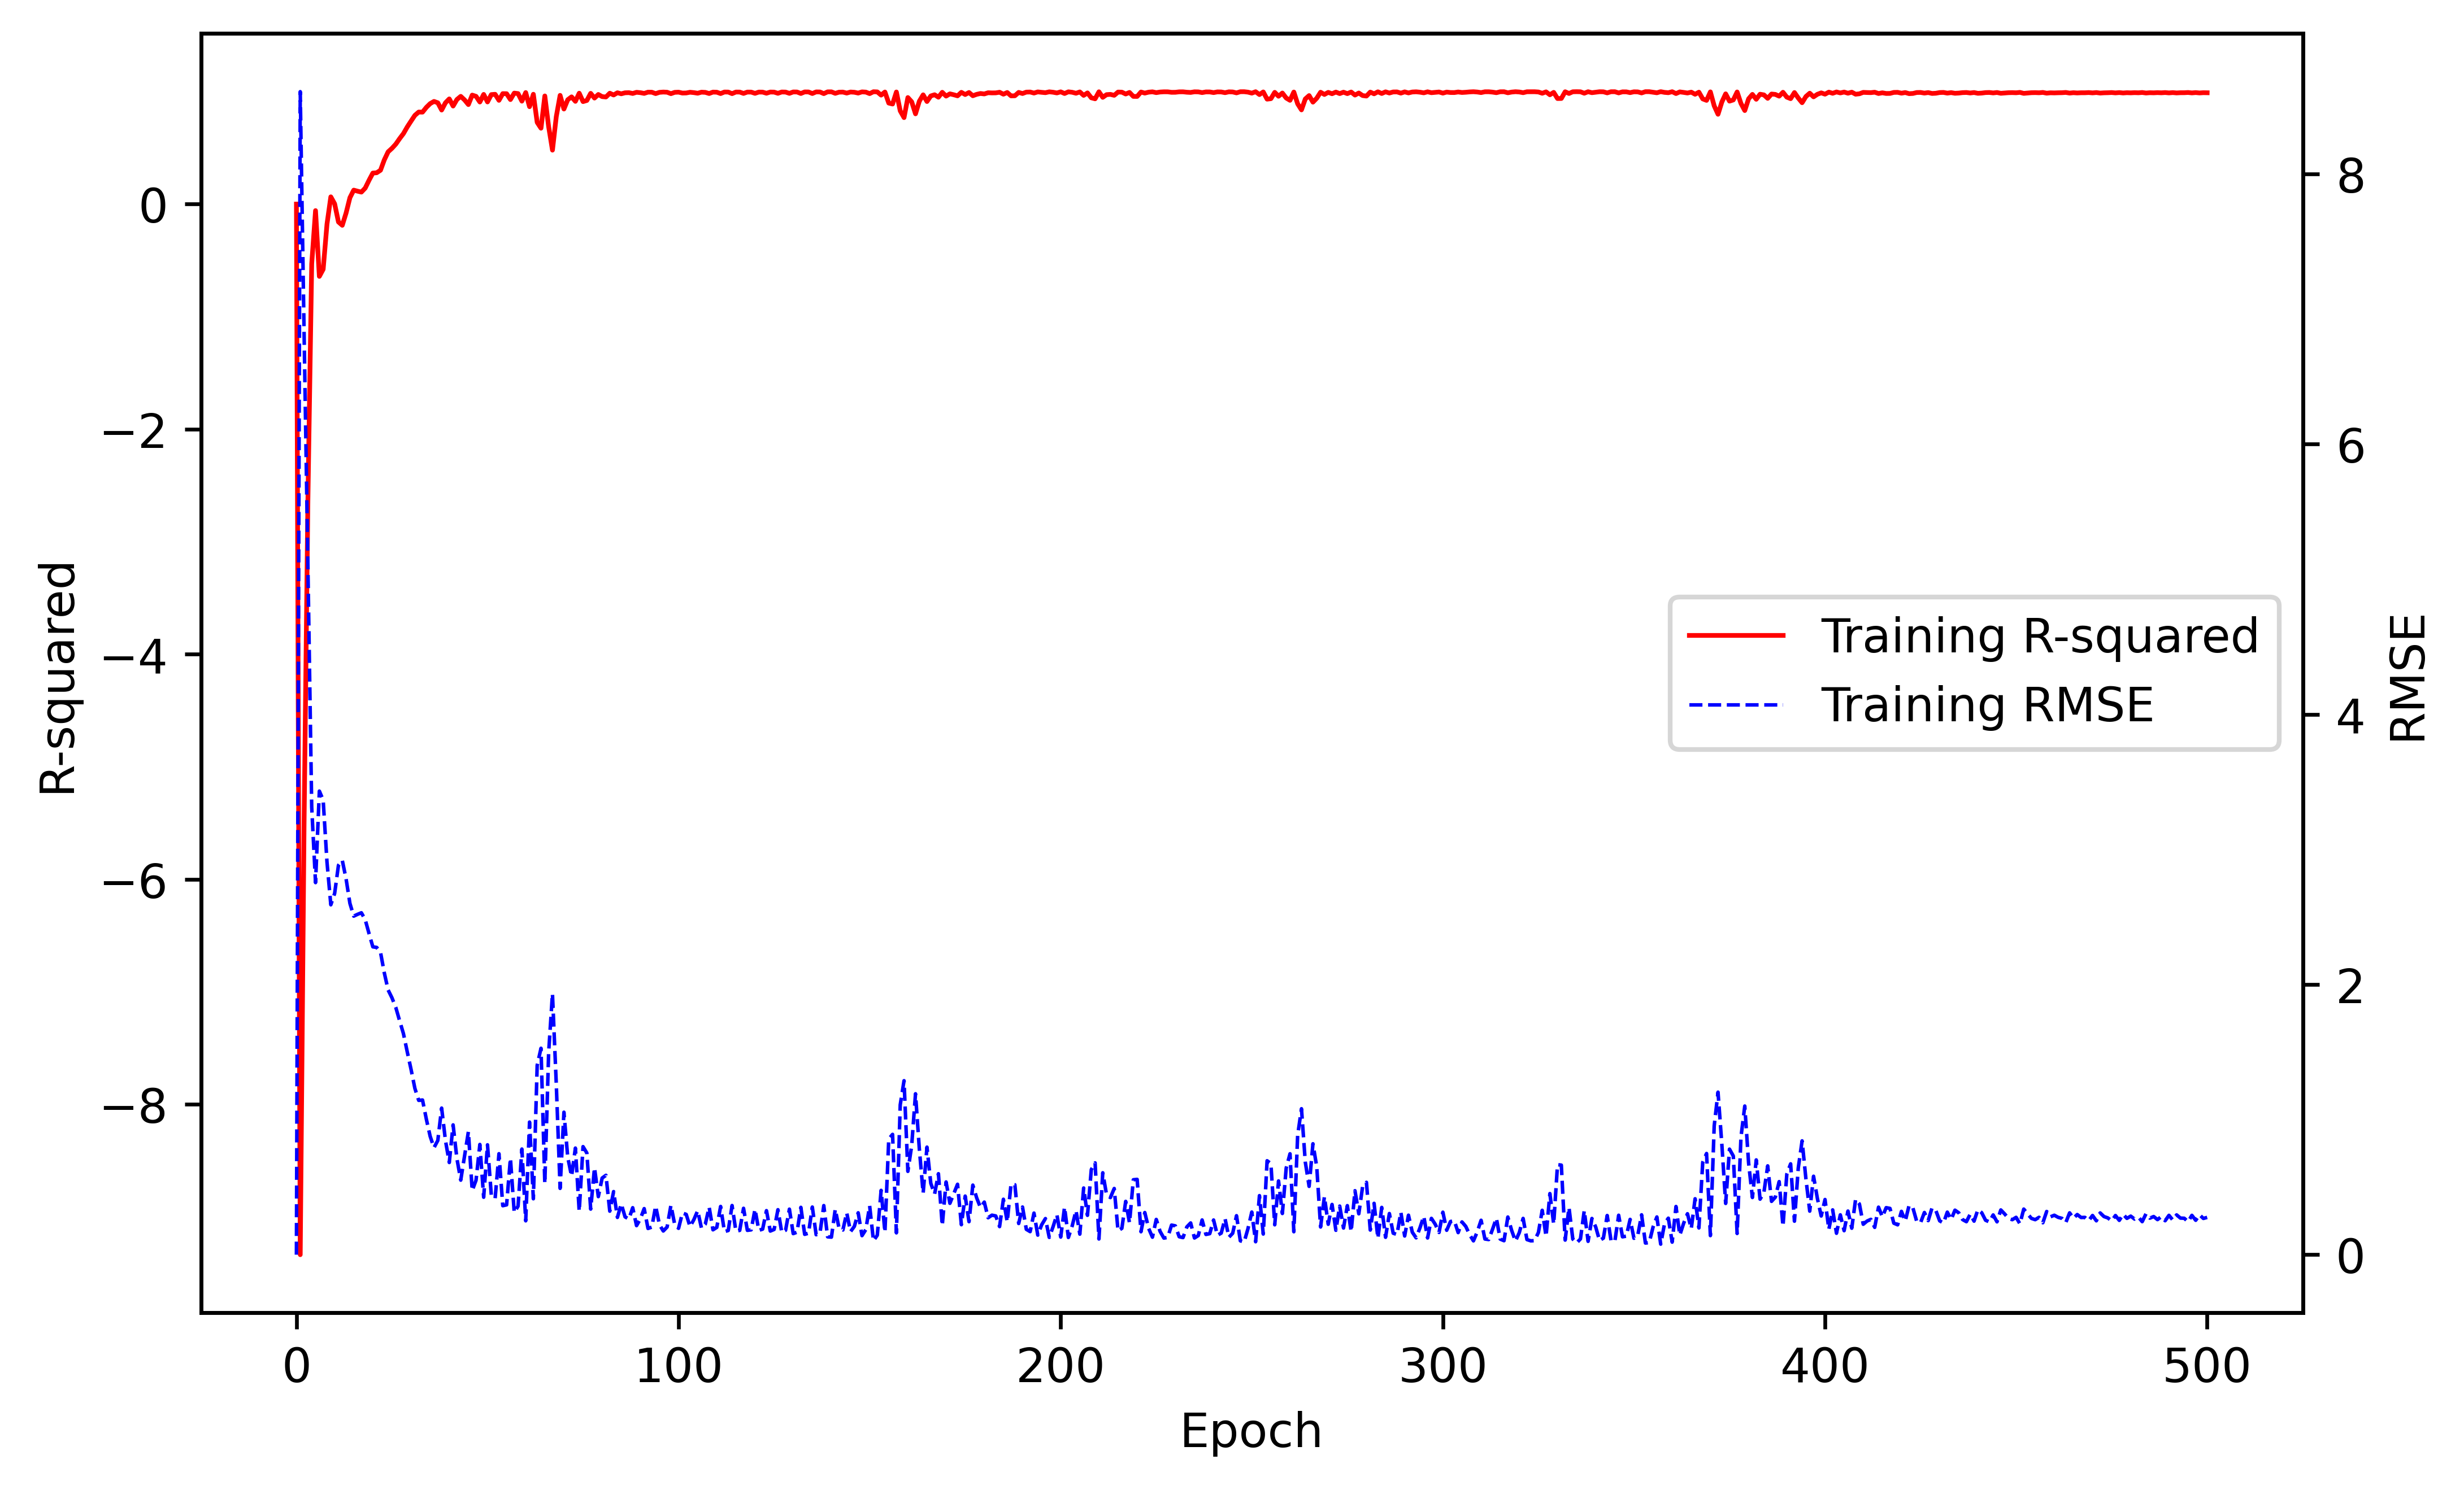

In [11]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8, 5),dpi=600)
ax2 = ax1.twinx()
lns_TrainingR_squared = ax1.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_r_square_train, color='red', linewidth=1, linestyle='-', label="Training Acc")
lns_TrainingRMSE=ax2.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_rmse_train, color='blue', linewidth=0.75, linestyle='--', label="Training RMSE")
# lns_TrainingR_squared = ax1.plot((np.arange(200)), fig_r_square_train[0:200], color='red', linewidth=1, linestyle='-', label="Training Acc")
# lns_TrainingRMSE=ax2.plot((np.arange(200)), fig_rmse_train[0:200], color='blue', linewidth=0.75, linestyle='--', label="Training RMSE")
lns_R_squaredRMSE=lns_TrainingAcc+lns_TrainingRMSE
label_TrainingR_squared=["Training R-squared"]
label_TrainingRMSE=["Training RMSE"]
label_R_squaredRMSE=label_TrainingR_squared+label_TrainingRMSE
plt.legend(lns_R_squaredRMSE,label_R_squaredRMSE, loc=5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('R-squared')
ax2.set_ylabel('RMSE')

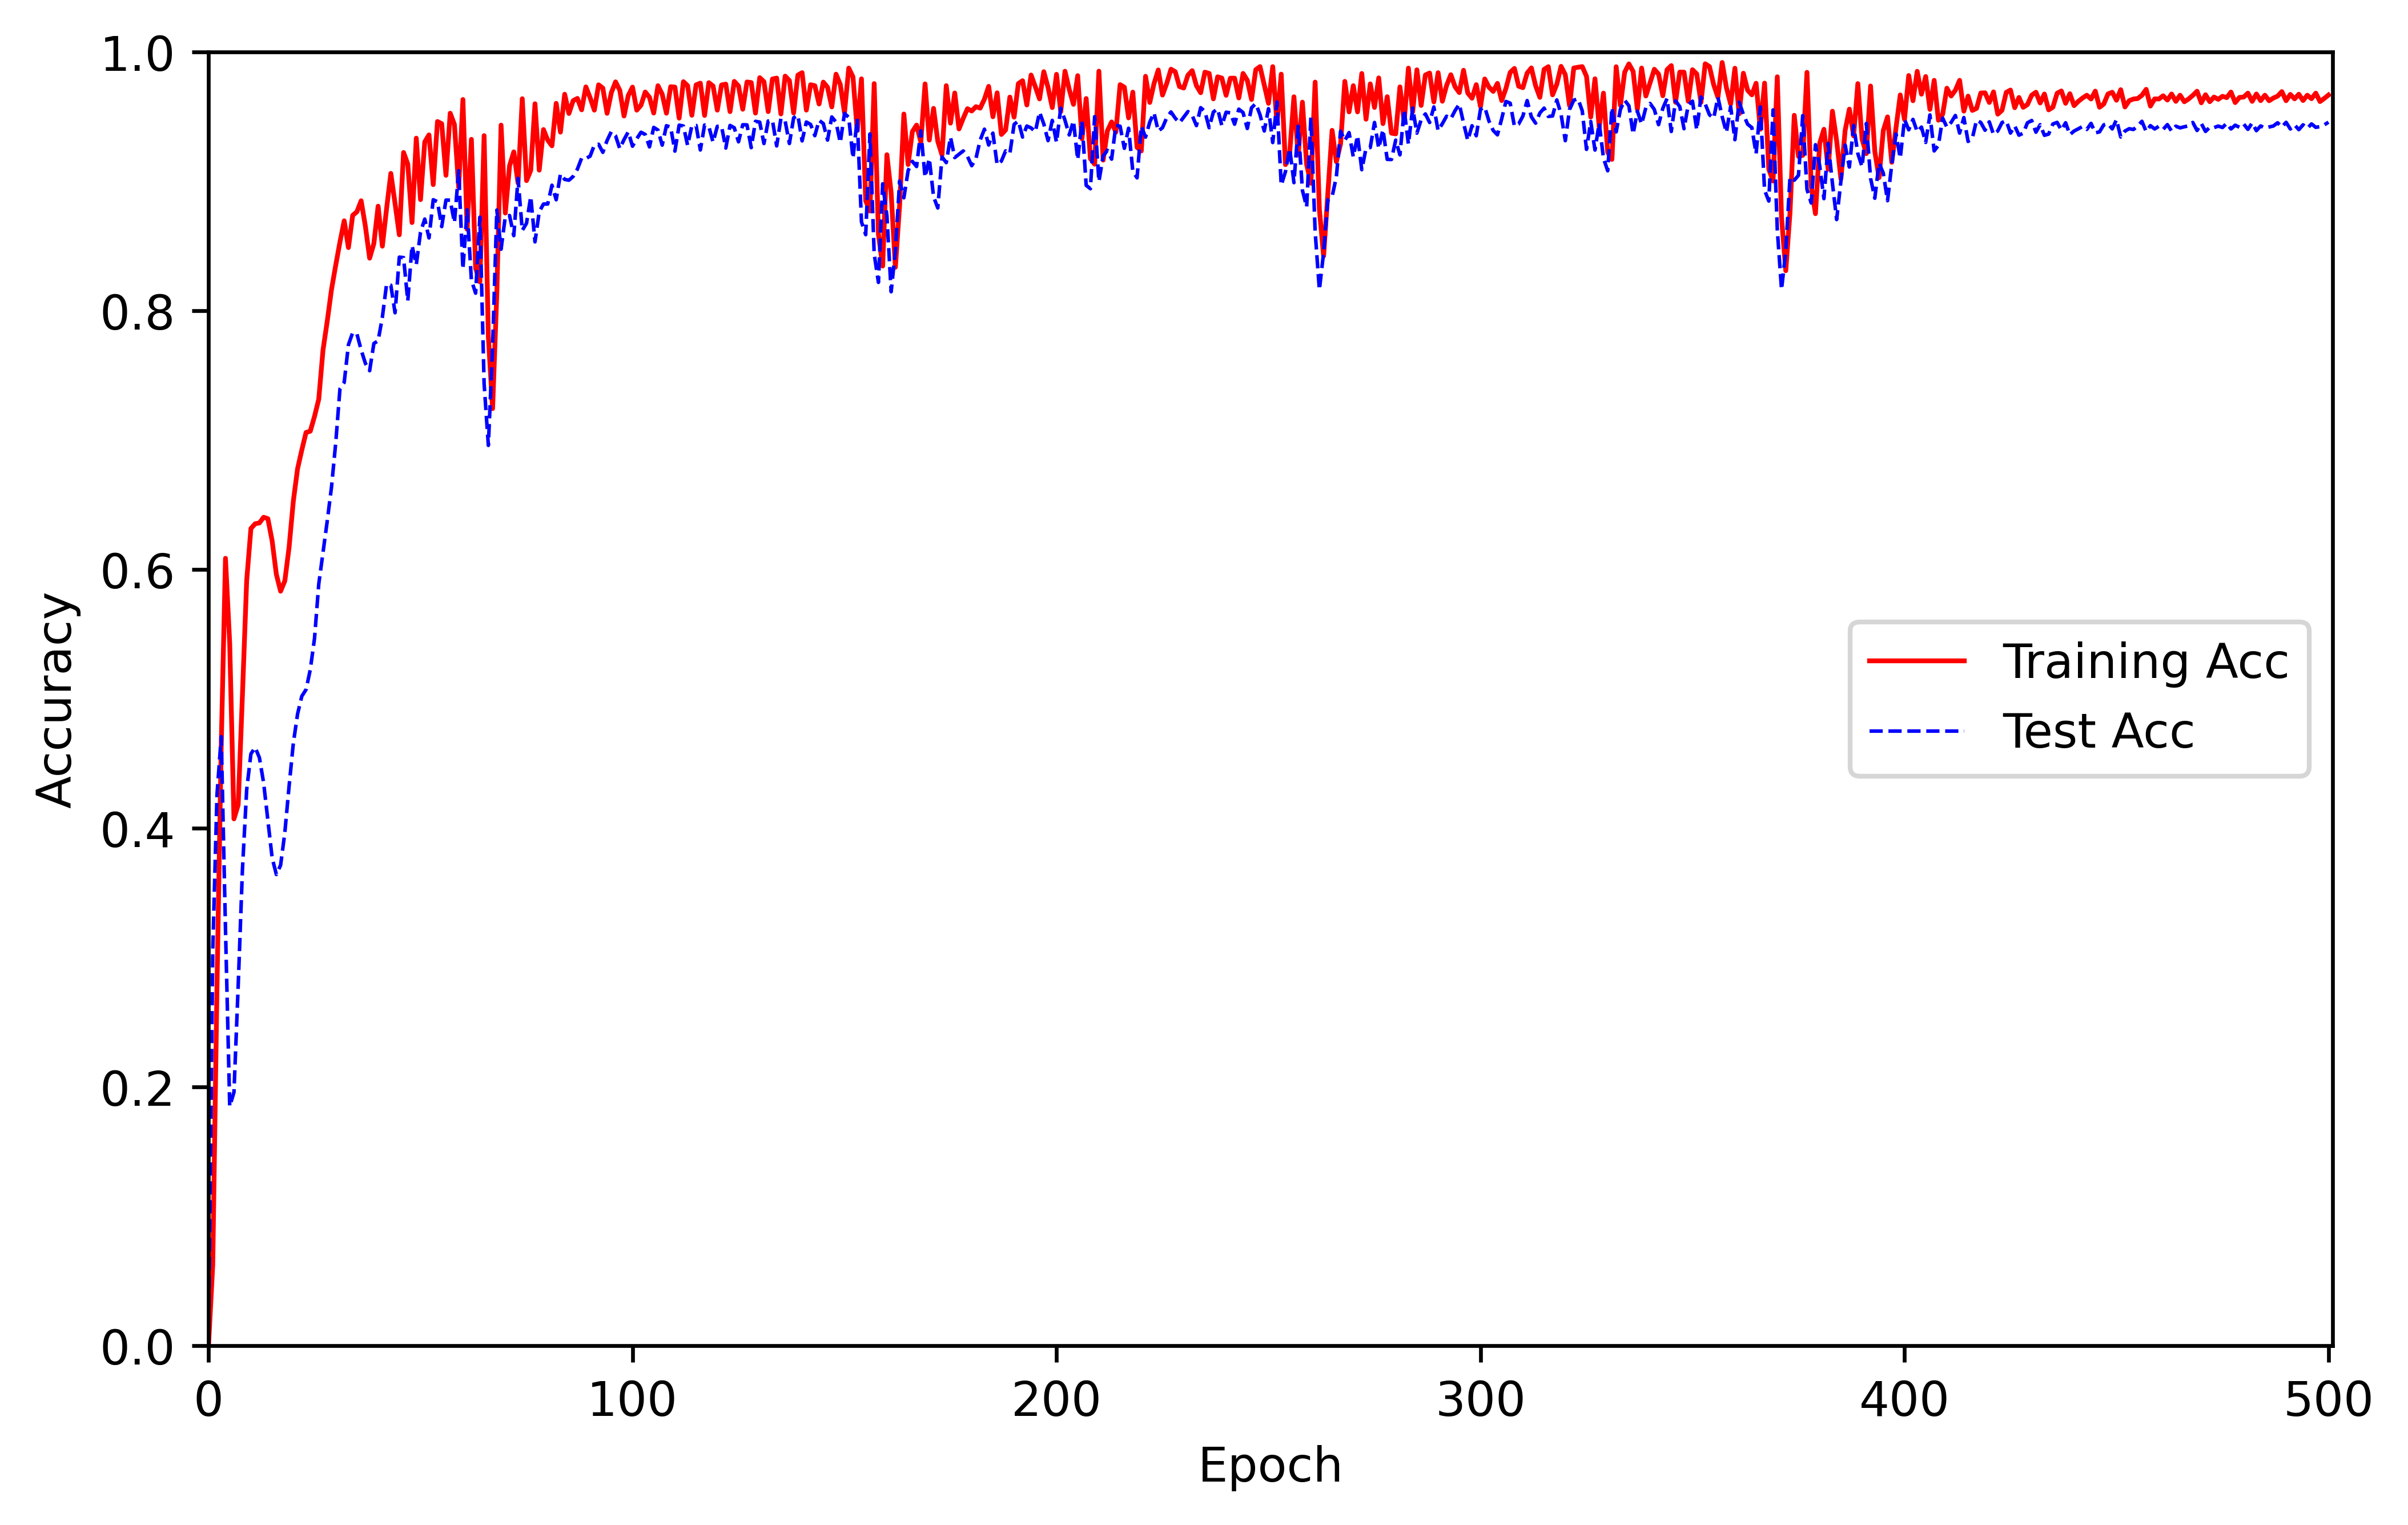

In [12]:
#创建数据
x = np.arange(int(np.ceil((max_iters+1) / interval)))
# x = np.arange(int(200))
y1 = fig_acc_train
y2 = fig_acc_test
#创建figure窗口
plt.figure(figsize=(8, 5),dpi=600)
#画曲线1
lns_TrainingAcc=plt.plot(x, y1, color='red', linewidth=1, linestyle='-', label="Train Acc")
#画曲线2
lns_TestAcc=plt.plot(x, y2, color='blue', linewidth=0.75, linestyle='--', label="Test Acc")
lns_Acc=lns_TrainingAcc+lns_TestAcc
label_TrainingAcc=["Training Acc"]
label_TestAcc=["Test Acc"]
label_Acc=label_TrainingAcc+label_TestAcc

#设置坐标轴范围
plt.xlim((0, 501))
plt.ylim((0, 1))
#设置坐标轴名称
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#设置坐标轴刻度
# my_x_ticks = np.arange(0, int(np.ceil((max_iters+1) / interval)), 25)
# my_y_ticks = np.arange(0, 1.2, 0.2)
# plt.xticks(my_x_ticks)
# plt.yticks(my_y_ticks)
label_Acc=label_TrainingAcc+label_TestAcc
plt.legend(lns_Acc,label_Acc, loc=5) 
#显示出所有设置

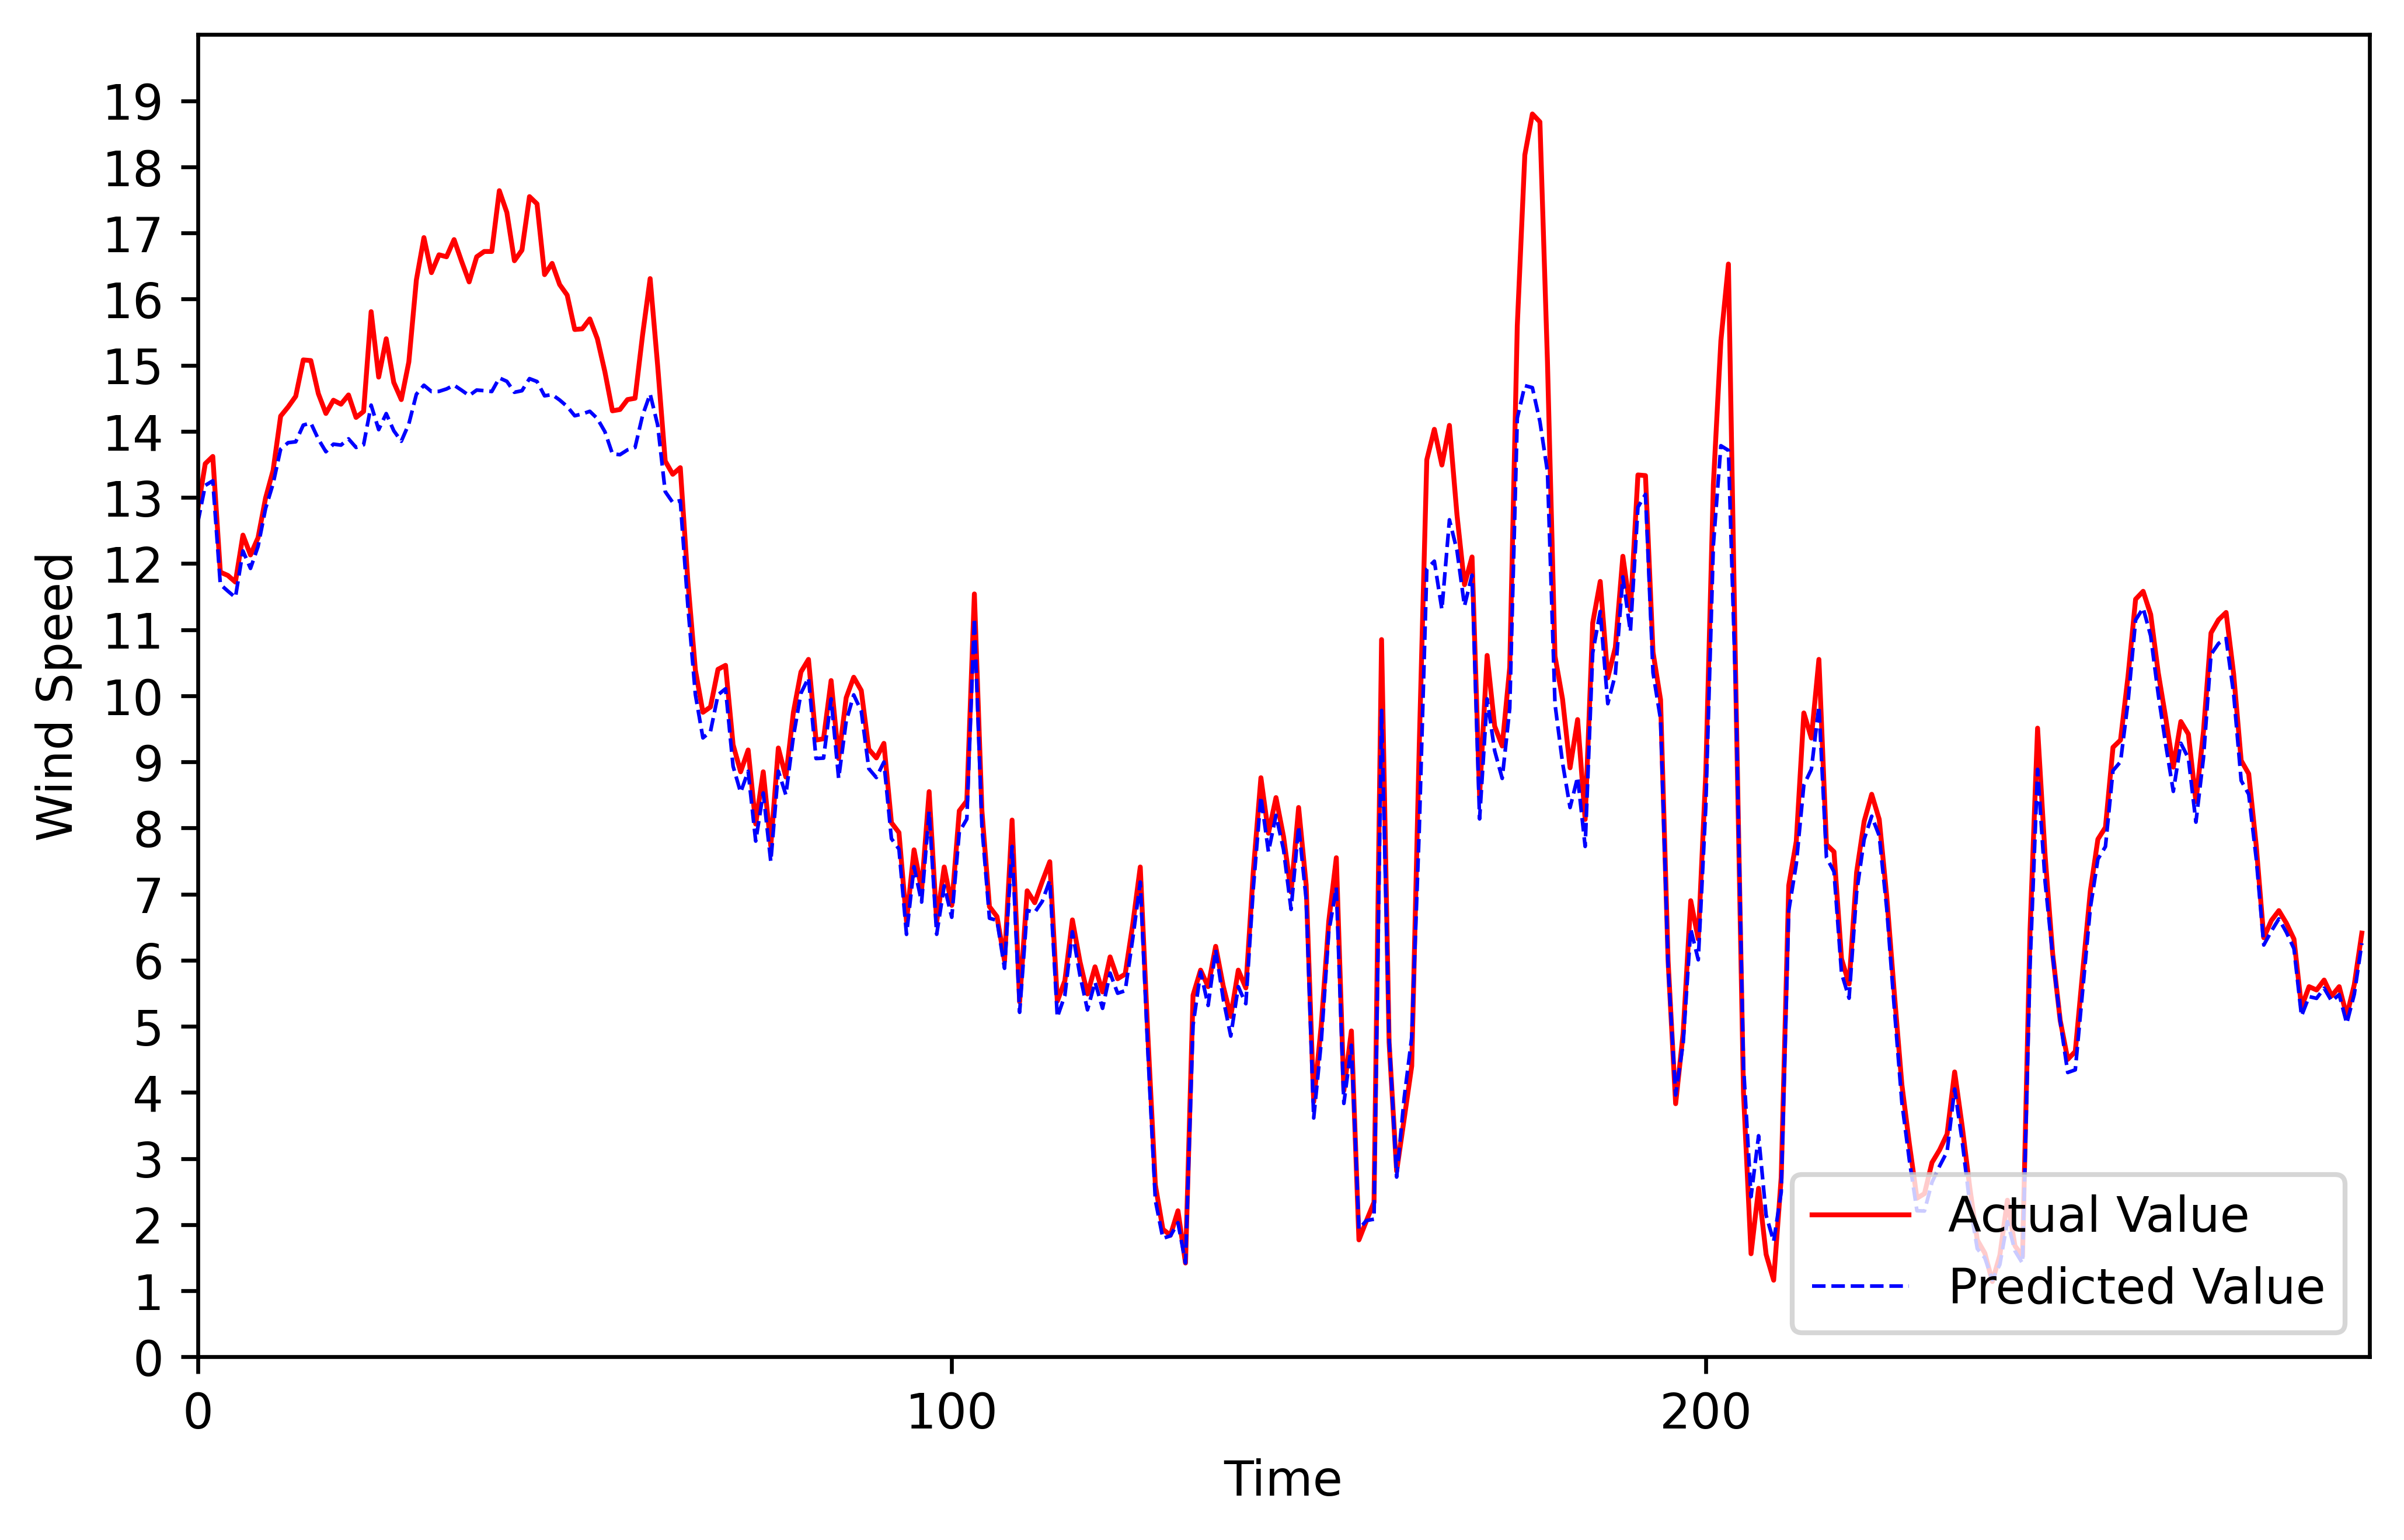

In [13]:
#创建数据
x = np.arange(len(fig_val))
y1 = fig_val
y2 = fig_prediction
#创建figure窗口
plt.figure(figsize=(8, 5),dpi=600)
#画曲线1
lns_ActualValue=plt.plot(x, y1, color='red', linewidth=1, linestyle='-', label="Actual Value")
#画曲线2
lns_PredictedValue=plt.plot(x, y2, color='blue', linewidth=0.75, linestyle='--', label="Predicted Value")
lns_ActualValuePredictedValue=lns_ActualValue+lns_PredictedValue
label_ActualValue=["Actual Value"]
label_PredictedValue=["Predicted Value"]
label_ActualValuePredictedValue=label_ActualValue+label_PredictedValue

#设置坐标轴范围
plt.xlim((0, 288))
plt.ylim((0, 20))
#设置坐标轴名称
plt.xlabel('Time')
plt.ylabel('Wind Speed')
#设置坐标轴刻度
my_x_ticks = np.arange(0, len(x), 100)
my_y_ticks = np.arange(0, 20, 1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.legend(lns_ActualValuePredictedValue,label_ActualValuePredictedValue, loc=4) 

In [14]:
for i in range(len(fig_val)):
    print(fig_val[i][0])

12.81
13.51
13.62
11.87
11.82
11.72
12.43
12.13
12.39
12.99
13.41
14.23
14.37
14.53
15.08
15.07
14.57
14.27
14.47
14.41
14.55
14.21
14.3
15.81
14.82
15.4
14.74
14.48
15.05
16.29
16.93
16.4
16.67
16.64
16.9
16.57
16.26
16.64
16.72
16.72
17.64
17.31
16.58
16.74
17.55
17.44
16.37
16.54
16.22
16.06
15.54
15.55
15.7
15.4
14.9
14.31
14.33
14.48
14.5
15.46
16.31
14.99
13.55
13.35
13.45
11.74
10.39
9.75
9.83
10.4
10.46
9.26
8.85
9.18
8.06
8.85
7.73
9.21
8.77
9.75
10.36
10.55
9.33
9.35
10.23
9.05
9.97
10.28
10.08
9.19
9.06
9.28
8.08
7.93
6.59
7.67
7.06
8.55
6.58
7.41
6.83
8.26
8.41
11.54
8.26
6.81
6.66
5.99
8.12
5.37
7.05
6.87
7.19
7.49
5.38
5.69
6.61
5.98
5.49
5.9
5.52
6.05
5.72
5.79
6.54
7.41
4.88
2.6
1.93
1.84
2.21
1.42
5.47
5.85
5.6
6.21
5.61
5.15
5.85
5.58
7.36
8.76
7.92
8.46
7.87
7.03
8.31
7.14
3.86
5.01
6.59
7.55
4.03
4.93
1.77
2.06
2.34
10.85
4.76
2.81
3.6
4.4
9.25
13.57
14.03
13.49
14.09
12.74
11.68
12.1
8.49
10.61
9.54
9.24
10.43
15.6
18.18
18.8
18.68
15.06
10.6
9.95
8.91
9.64
8.13
11

In [15]:
for i in range(len(fig_prediction)):
    print(fig_prediction[i][0])

12.611376
13.181631
13.251491
11.684685
11.5831585
11.48663
12.1909485
11.9264345
12.257509
12.832386
13.2085495
13.732168
13.828401
13.841457
14.09344
14.126347
13.881527
13.691512
13.805958
13.791405
13.886042
13.756177
13.796343
14.395873
14.025215
14.26794
14.009429
13.849827
14.112667
14.560337
14.697079
14.601657
14.604019
14.640872
14.697342
14.621132
14.540804
14.6239
14.614941
14.602098
14.807172
14.755764
14.590514
14.614086
14.796812
14.752701
14.536707
14.555467
14.47341
14.375264
14.235341
14.262522
14.302898
14.192368
13.994165
13.658931
13.64647
13.719496
13.755074
14.241752
14.564953
14.09428
13.087882
12.923575
12.951319
11.3648205
10.018093
9.362732
9.457035
10.014631
10.105606
8.933662
8.53854
8.857949
7.801896
8.530222
7.492104
8.859875
8.500742
9.384311
10.038652
10.271456
9.050727
9.057068
9.953053
8.750584
9.616047
10.013306
9.770655
8.897482
8.762741
8.997534
7.838493
7.680553
6.3908343
7.4151187
6.879536
8.248815
6.3923078
7.12501
6.649659
7.9393797
8.135974
11

In [16]:
for i in range(len(fig_acc_train)):
    print(fig_acc_train[i])

0.0
0.06271147727966309
0.2782704830169678
0.4639933109283447
0.6087572574615479
0.5428189039230347
0.4073336720466614
0.4182385206222534
0.5031837821006775
0.5914573669433594
0.631804883480072
0.6354784369468689
0.636102557182312
0.6405020952224731
0.6393673419952393
0.6223494410514832
0.5963457822799683
0.5833331346511841
0.5913347005844116
0.6172398924827576
0.6528465747833252
0.677954375743866
0.692449688911438
0.7060225009918213
0.7070194482803345
0.7184513807296753
0.7317237854003906
0.7696318030357361
0.7920222282409668
0.8164079189300537
0.835297703742981
0.8532603979110718
0.8696489334106445
0.8489424586296082
0.873847484588623
0.8766223788261414
0.885148823261261
0.8653510808944702
0.8407583236694336
0.8521240949630737
0.8809489607810974
0.850027322769165
0.8790891766548157
0.9063065648078918
0.8828991651535034
0.8588275909423828
0.9224722385406494
0.9134525060653687
0.8682729601860046
0.9335353374481201
0.8860317468643188
0.9306378960609436
0.9360604882240295
0.8976259231567

In [17]:
for i in range(len(fig_r_square_train)):
    print(fig_r_square_train[i])

0.0
-9.3351411819458
-5.517059326171875
-2.6403086185455322
-0.5306506156921387
-0.05767261981964111
-0.6422861814498901
-0.579254150390625
-0.17764341831207275
0.06465387344360352
0.002950429916381836
-0.15881967544555664
-0.1883234977722168
-0.0785287618637085
0.05714750289916992
0.1242896318435669
0.11486554145812988
0.10673820972442627
0.14236676692962646
0.21187442541122437
0.2758737802505493
0.2786400318145752
0.30087345838546753
0.3933296203613281
0.46477943658828735
0.4957176446914673
0.5328301191329956
0.581605076789856
0.6264108419418335
0.6855829954147339
0.7378437519073486
0.7887381315231323
0.818078339099884
0.8171865940093994
0.8596762418746948
0.8930215835571289
0.9124786257743835
0.9003117084503174
0.8357940912246704
0.900422215461731
0.9350839853286743
0.8712717294692993
0.9295886754989624
0.9575484991073608
0.9256452322006226
0.8843954801559448
0.9686565399169922
0.9576846361160278
0.9071407914161682
0.9747892618179321
0.9077657461166382
0.973038911819458
0.9757820367

In [18]:
for i in range(len(fig_rmse_train)):
    print(fig_rmse_train[i])

0.0
8.60897445678711
6.836267948150635
5.109311103820801
3.313075065612793
2.754031181335449
3.4317657947540283
3.365264892578125
2.9060301780700684
2.589878559112549
2.6739397048950195
2.882711172103882
2.919178009033203
2.7810518741607666
2.600250005722046
2.5059561729431152
2.519404172897339
2.530944347381592
2.4799563884735107
2.37733793258667
2.2787692546844482
2.2744126319885254
2.2390878200531006
2.085785388946533
1.959113597869873
1.901647925376892
1.830335259437561
1.7321537733078003
1.6367802619934082
1.5015722513198853
1.3711134195327759
1.2308461666107178
1.1421822309494019
1.144978404045105
1.0031338930130005
0.875873327255249
0.7922283411026001
0.8455033898353577
1.0851445198059082
0.845034658908844
0.682290256023407
0.9607939124107361
0.7105823159217834
0.551746666431427
0.7302097678184509
0.9105014801025391
0.4740963876247406
0.5508613586425781
0.8160293102264404
0.42519307136535645
0.8132786154747009
0.43970537185668945
0.41673702001571655
0.7474422454833984
0.36250510

0.26815474033355713
0.2759925425052643


In [ ]:
a=[1,2,3,4,5,6,7,8]
a[-7:-1]